# Missaligment effects

This notebooks explore the possible relationships between different signal metrics and the missaligments of each experiment

In [1]:
import pandas as pd
import numpy as np
import time
import os
import glob
import json
from collections import Counter, defaultdict
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from scipy.signal import savgol_filter

In [2]:
# Directory where the original data is stored
ORIGINAL_DATA_DIR = '../../../EXOSAFE-DATA'

# Number of force cells in the robotic leg
N_CELLS = 8

pd.set_option('display.max_columns', None)

In [3]:
data_ls = glob.glob(ORIGINAL_DATA_DIR + '/*/*.xlsx')

print('Files found ({}):'.format(len(data_ls)))
print([file.split('/')[-1] for file in data_ls])

Files found (101):
['01-06022021.xlsx', '02-06022021.xlsx', '03-06022021.xlsx', '07-06022021.xlsx', '08-06022021.xlsx', '10-06022021.xlsx', '03-08022021.xlsx', '04-08022021.xlsx', '02-10022021.xlsx', '03-10022021.xlsx', '04-10022021.xlsx', '05-10022021.xlsx', '01-10032021.xlsx', '01-12022021.xlsx', '02-12022021.xlsx', '03-12022021.xlsx', '04-12022021.xlsx', '05-12022021.xlsx', '06-12022021.xlsx', '07-12022021.xlsx', '02-15022021.xlsx', '03-15022021.xlsx', '04-15022021.xlsx', '01-16022021.xlsx', '02-16022021.xlsx', '03-16022021.xlsx', '04-16022021.xlsx', '05-16022021.xlsx', '06-16022021.xlsx', '02-17022021.xlsx', '03-17022021.xlsx', '04-17022021.xlsx', '01-19022021.xlsx', '010-19022021.xlsx', '011-19022021.xlsx', '012-19022021.xlsx', '013-19022021.xlsx', '014-19022021.xlsx', '015-19022021.xlsx', '016-19022021.xlsx', '017-19022021.xlsx', '018-19022021.xlsx', '02-19022021.xlsx', '03-19022021.xlsx', '04-19022021.xlsx', '05-19022021.xlsx', '06-19022021.xlsx', '07-19022021.xlsx', '08-1902202

In [4]:
# Dictionary to exclude specific experiments (date: [experiment ids])
# These experiments are excluded by lack of data
# EXPERIMENTS_TO_EXCLUDE = {
#     '06022021': ['01', '02', '03', '07', '08', '10'],
#     '08022021': ['03', '04'],
#     '10022021': ['02', '03', '04', '05'],
#     '12022021': ['01', '02', '03', '04', '05', '06', '07'],
#     '15022021': ['02', '03', '04'],
#     '16022021': ['01', '02', '03', '04', '05', '06'],
#     '17022021': ['02', '03', '04']
# }

EXPERIMENTS_TO_EXCLUDE = {
    '06022021': ['01', '02', '03', '07', '08', '10'],
    '08022021': ['03', '04'],
    '10022021': ['02', '03', '04', '05'],
    '12022021': ['01', '02', '03', '04', '05', '06', '07'],
    '15022021': ['02', '03', '04'],
    '26032021': ['01', '02', '03', '04', '06', '07', '09', '011', '012'],
    '21042021': ['02', '03', '04', '05', '06', '07', '08']
}

# Exclude some experiments from the list of files to process
for exp_date, exp_ids in EXPERIMENTS_TO_EXCLUDE.items():
    for i in exp_ids:
        data_ls.remove(ORIGINAL_DATA_DIR + '/{}/{}-{}.xlsx'.format(exp_date, i, exp_date))
        
print('Files to process ({}):'.format(len(data_ls)))
print([file.split('/')[-1] for file in data_ls])

Files to process (63):
['01-10032021.xlsx', '01-16022021.xlsx', '02-16022021.xlsx', '03-16022021.xlsx', '04-16022021.xlsx', '05-16022021.xlsx', '06-16022021.xlsx', '02-17022021.xlsx', '03-17022021.xlsx', '04-17022021.xlsx', '01-19022021.xlsx', '010-19022021.xlsx', '011-19022021.xlsx', '012-19022021.xlsx', '013-19022021.xlsx', '014-19022021.xlsx', '015-19022021.xlsx', '016-19022021.xlsx', '017-19022021.xlsx', '018-19022021.xlsx', '02-19022021.xlsx', '03-19022021.xlsx', '04-19022021.xlsx', '05-19022021.xlsx', '06-19022021.xlsx', '07-19022021.xlsx', '08-19022021.xlsx', '09-19022021.xlsx', '01-22022021.xlsx', '010-22022021.xlsx', '011-22022021.xlsx', '012-22022021.xlsx', '013-22022021.xlsx', '014-22022021.xlsx', '015-22022021.xlsx', '016-22022021.xlsx', '017-22022021.xlsx', '018-22022021.xlsx', '019-22022021.xlsx', '02-22022021.xlsx', '03-22022021.xlsx', '04-22022021.xlsx', '05-22022021.xlsx', '06-22022021.xlsx', '07-22022021.xlsx', '08-22022021.xlsx', '09-22022021.xlsx', '01-24022021.xlsx

In [5]:
def compute_time_shift(exo_knee_pos, leg_knee_pos, data_res=0.01, window_size=51, pol_order=3, threshold=30, max_time_shift=10):
    '''
    Find the time shift between the exo knee position and the robotic leg knee position based on the local maximas
    
    Args:
    - exo_knee_pos (np.array): Exoeskeleton knee position signal.
    - leg_knee_pos (np.array): Robotic leg knee position signal.
    - data_res (float) [default = 0.01]: Time resolution of the data (0.01 = 100Hz)
    - window_size (int) [default = 51]: Window size to smooth the signals with savgol filter
    - pol_order (int) [default = 3]: Polinomial degree to smooth the signals with savgol filter
    - threshold (int) [default = 30]: Threshold to filter the 0 cross of the derivates of the signals
    - max_time_shift (int) [default = 10]: Max value of seconds to generate the cost function and find the minumum
    
    Return:
    - time_shift (float): Time shift between the exoeskeleton and robotic leg signals
    '''
    # Smooth the exo and leg position signal
    exo_arr_smooth = savgol_filter(exo_knee_pos, window_size, pol_order) # window size 51, polynomial order 3
    leg_arr_smooth = savgol_filter(leg_knee_pos, window_size, pol_order) 
    
    # Compute derivative of the signal to find de local maxima
    exo_dev = np.gradient(exo_arr_smooth, data_res)
    exo_dev_smooth = savgol_filter(exo_dev, window_size, pol_order) 
    leg_dev = np.gradient(leg_arr_smooth, data_res)
    leg_dev_smooth = savgol_filter(leg_dev, window_size, pol_order)
    
    # Find the x coordinate of the maximum points
    exo_idx_max = []
    searching = False
    for i in range(1, exo_dev_smooth.shape[0]):
        # Search for a point where the gradient is decreasing before cross 0
        if exo_dev_smooth[i - 1] > threshold and exo_dev_smooth[i] < threshold:
            searching = True
        # Only if the gradient is decreasing from a point higher than threshold,
        # then search for a 0 crossing
        if searching and exo_dev_smooth[i - 1] > 0 and exo_dev_smooth[i] < 0:
            searching = False
            exo_idx_max.append(i)

    leg_idx_max = []
    searching = False
    for i in range(1, leg_dev_smooth.shape[0]):
        # Search for a point where the gradient is decreasing before cross 0
        if leg_dev_smooth[i - 1] > threshold and leg_dev_smooth[i] < threshold:
            searching = True
        # Only if the gradient is decreasing from a point higher than threshold,
        # then search for a 0 crossing
        if searching and leg_dev_smooth[i - 1] > 0 and leg_dev_smooth[i] < 0:
            searching = False
            leg_idx_max.append(i)

    # Compute the location of the max points in time scale
    exo_maxs = np.array(np.arange(0, len(exo_arr) * data_res, data_res)[exo_idx_max])
    leg_maxs = np.array(np.arange(0, len(leg_arr) * data_res, data_res)[leg_idx_max])

    min_aux = np.min([len(exo_maxs), len(leg_maxs)])

    exo_maxs = exo_maxs[:min_aux]
    leg_maxs = leg_maxs[:min_aux]
    
    time_shift_ls = np.arange(0, max_time_shift, data_res)

    MAE_ls = []
    for ts in time_shift_ls:
        MAE_ls.append(mean_absolute_error(exo_maxs, leg_maxs - ts))

    time_shift = time_shift_ls[np.argmin(MAE_ls)]
    
    return time_shift

In [5]:
experiments = []

for file in data_ls:
    print(file)
    data_df = pd.read_excel(file, sheet_name=['Parameters', 'ForceCells'])
    
    # exo_arr = data_df['H3processed'].iloc[:, 1].values
    # leg_arr = data_df['Leg-Replica'].iloc[:, 3].values
    # time_shift = compute_time_shift(exo_arr, leg_arr)
    
    d = {'params': {}, 'force_cells': {}}

    if file.split('/')[-2] in ['16022021', '17022021']:
        d['params']['ExoHipMissaligment'] = data_df['Parameters']['ExoHip'][0] / 10
        d['params']['ExoKneeMissaligment'] = data_df['Parameters']['ExoKnee'][0] / 10
        d['params']['MarchVelocity'] = float('NaN')
    else:
        d['params']['ExoHipMissaligment'] = data_df['Parameters']['ExoHip'][2]
        d['params']['ExoKneeMissaligment'] = data_df['Parameters']['ExoKnee'][2]
        d['params']['MarchVelocity'] = data_df['Parameters']['MarchVelocity'][0]

    d['params']['SkinConfig'] = data_df['Parameters']['SkinConfig'][0]
    d['params']['TimeShift'] = data_df['Parameters']['TimeShift'][0] #time_shift
    
    for cell in range(1, N_CELLS + 1):
        for force in ['x', 'y', 'z']:
            d['force_cells']['F{}{}_max'.format(cell, force)] = np.max(data_df['ForceCells']['F{}{}'.format(cell, force)])
            d['force_cells']['F{}{}_min'.format(cell, force)] = np.min(data_df['ForceCells']['F{}{}'.format(cell, force)])
            d['force_cells']['F{}{}_mean'.format(cell, force)] = np.mean(data_df['ForceCells']['F{}{}'.format(cell, force)])
            d['force_cells']['F{}{}_median'.format(cell, force)] = np.median(data_df['ForceCells']['F{}{}'.format(cell, force)])
            d['force_cells']['F{}{}_std'.format(cell, force)] = np.std(data_df['ForceCells']['F{}{}'.format(cell, force)])
            
            
    experiments.append(d)


../../../EXOSAFE-DATA/10032021/01-10032021.xlsx
../../../EXOSAFE-DATA/16022021/01-16022021.xlsx
../../../EXOSAFE-DATA/16022021/02-16022021.xlsx
../../../EXOSAFE-DATA/16022021/03-16022021.xlsx
../../../EXOSAFE-DATA/16022021/04-16022021.xlsx
../../../EXOSAFE-DATA/16022021/05-16022021.xlsx
../../../EXOSAFE-DATA/16022021/06-16022021.xlsx
../../../EXOSAFE-DATA/17022021/02-17022021.xlsx
../../../EXOSAFE-DATA/17022021/03-17022021.xlsx
../../../EXOSAFE-DATA/17022021/04-17022021.xlsx
../../../EXOSAFE-DATA/19022021/01-19022021.xlsx
../../../EXOSAFE-DATA/19022021/010-19022021.xlsx
../../../EXOSAFE-DATA/19022021/011-19022021.xlsx
../../../EXOSAFE-DATA/19022021/012-19022021.xlsx
../../../EXOSAFE-DATA/19022021/013-19022021.xlsx
../../../EXOSAFE-DATA/19022021/014-19022021.xlsx
../../../EXOSAFE-DATA/19022021/015-19022021.xlsx
../../../EXOSAFE-DATA/19022021/016-19022021.xlsx
../../../EXOSAFE-DATA/19022021/017-19022021.xlsx
../../../EXOSAFE-DATA/19022021/018-19022021.xlsx
../../../EXOSAFE-DATA/19022021/

In [6]:
len(experiments)

63

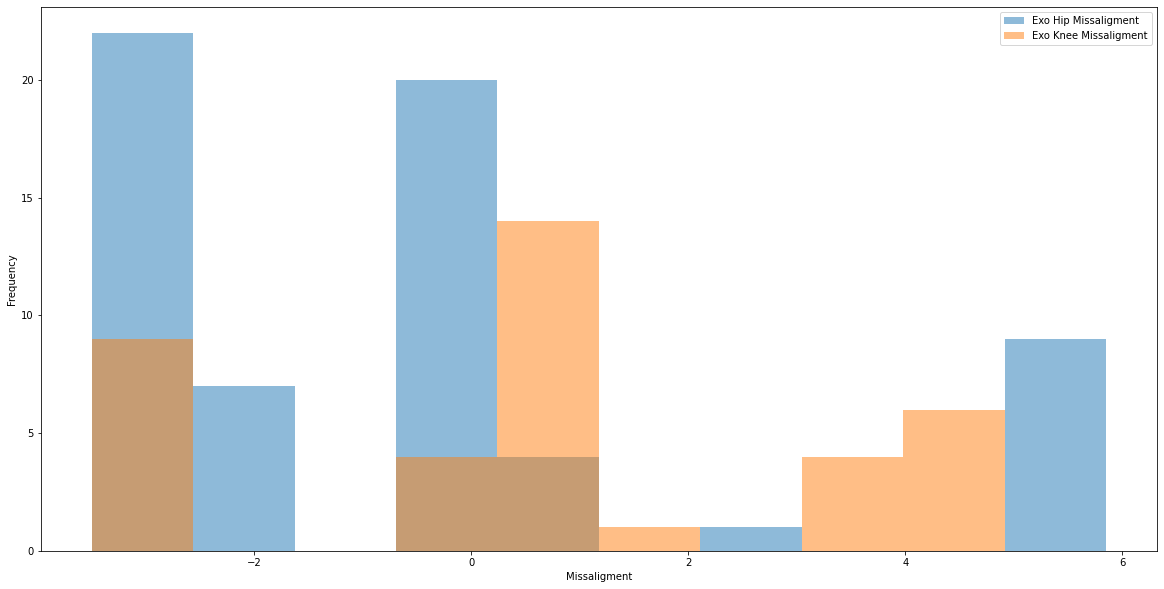

In [7]:
plt.figure(figsize=(20,10))
_, bins, _ = plt.hist([exp['params']['ExoHipMissaligment'] for exp in experiments], bins=10, label='Exo Hip Missaligment', alpha=0.5)
_ = plt.hist([exp['params']['ExoKneeMissaligment'] for exp in experiments], bins=bins, label='Exo Knee Missaligment', alpha=0.5)
plt.legend()
plt.xlabel('Missaligment')
plt.ylabel('Frequency')
plt.show()

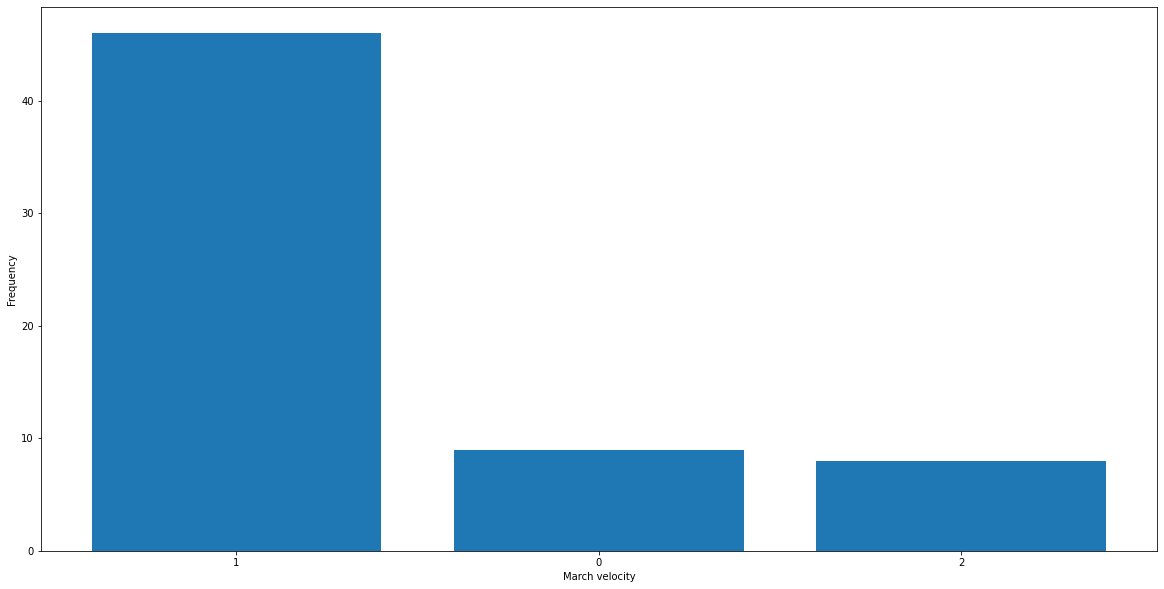

In [16]:
plt.figure(figsize=(20,10))

march_velocity = Counter([int(exp['params']['MarchVelocity']) if str(exp['params']['MarchVelocity']) != 'nan' else 0 for exp in experiments])

plt.bar([str(int(x)) for x in march_velocity.keys()], march_velocity.values())
plt.xlabel('March velocity')
plt.ylabel('Frequency')
plt.show()

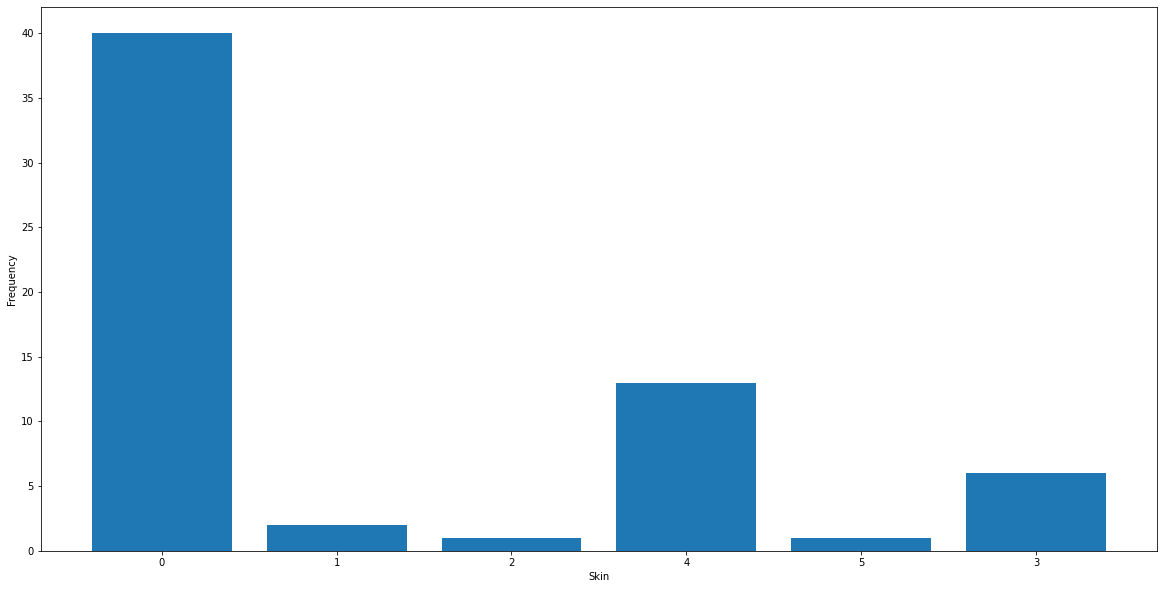

In [18]:
plt.figure(figsize=(20,10))

skin_config = Counter([exp['params']['SkinConfig'] for exp in experiments])

plt.bar([str(int(x)) for x in skin_config.keys()], skin_config.values())
plt.xlabel('Skin')
plt.ylabel('Frequency')
plt.show()

In [19]:
metric = 'max'

experiments_filter = [exp for exp in experiments if exp['params']['MarchVelocity'] == 1 and exp['params']['SkinConfig'] == 0]

x, y1, y2, y3, y4 = [], [], [], [], []
for exp in experiments_filter:
    x.append(exp['params']['ExoKneeMissaligment'])
    
    for idx, y, label in zip([3, 4, 7, 8], [y1, y2, y3, y4], ['bottom-front', 'bottom-back', 'top-front', 'top-back']):
        y.append(np.sqrt(exp['force_cells']['F{}x_{}'.format(idx, metric)] ** 2 + exp['force_cells']['F{}y_{}'.format(idx, metric)] ** 2 + exp['force_cells']['F{}z_{}'.format(idx, metric)] ** 2))
    

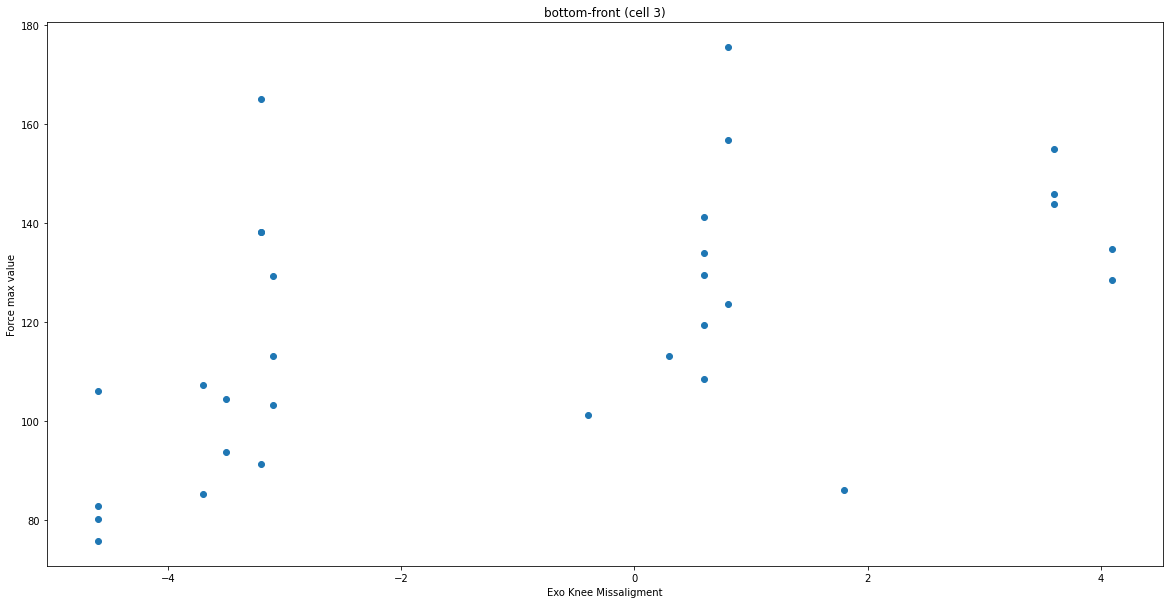

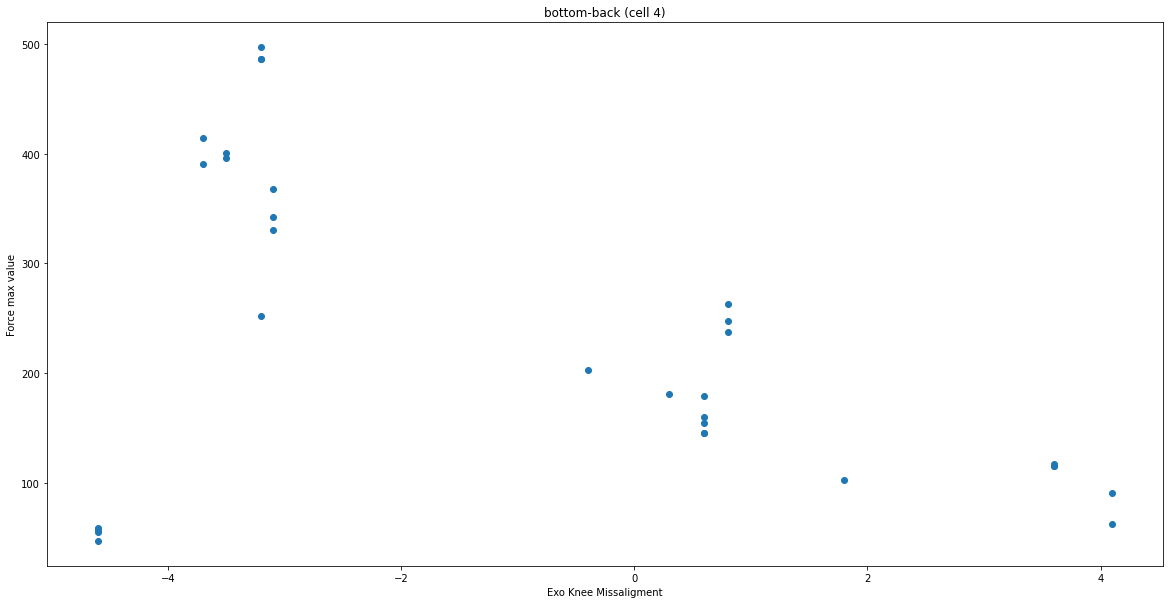

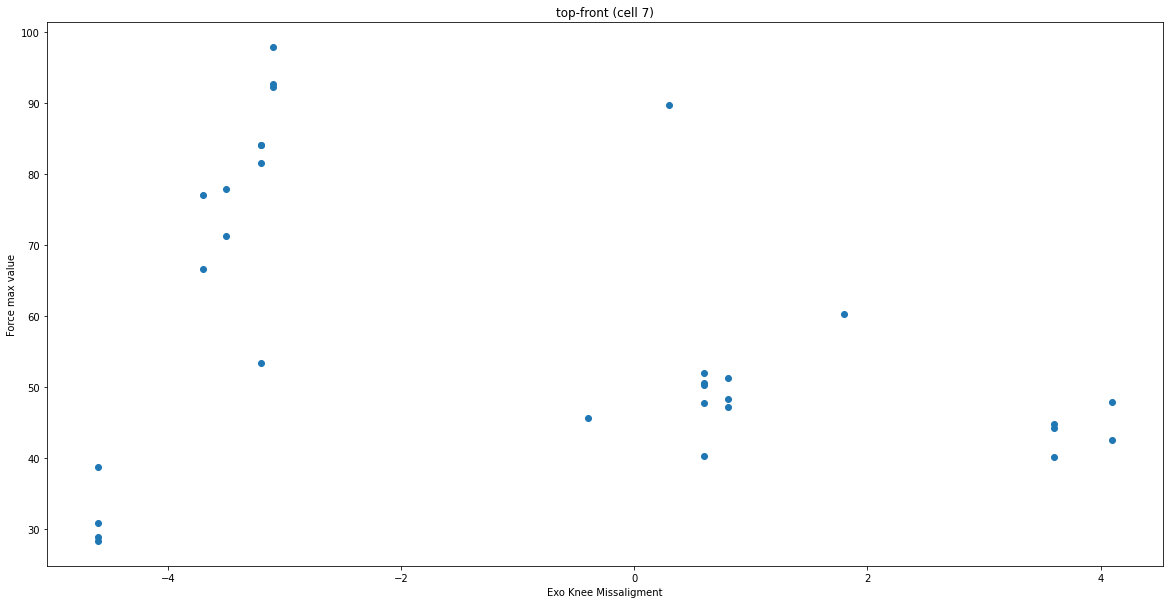

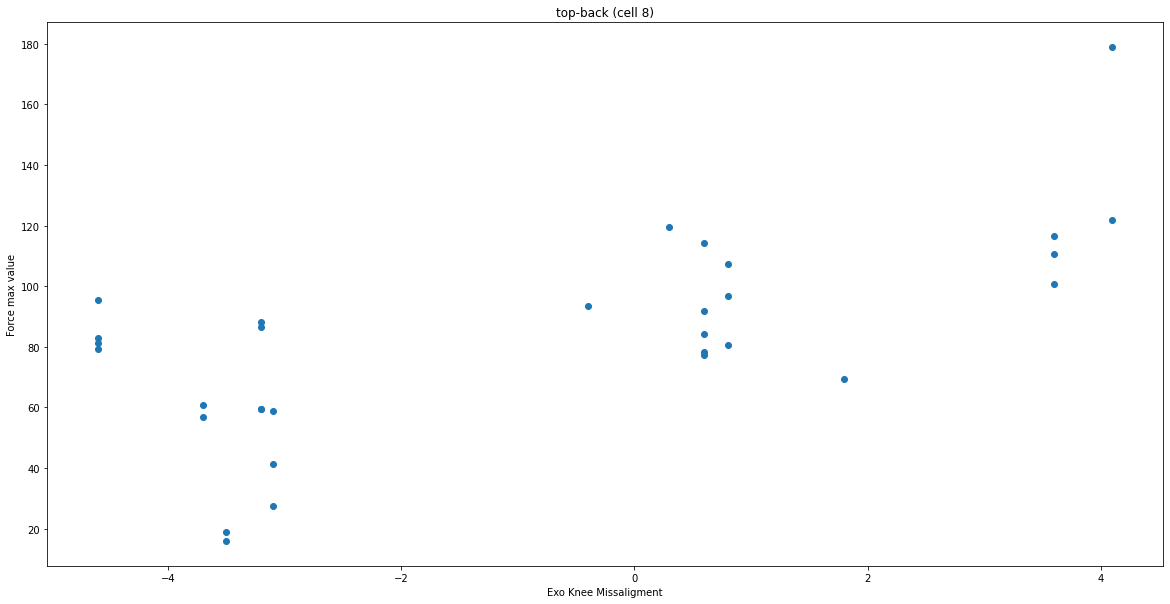

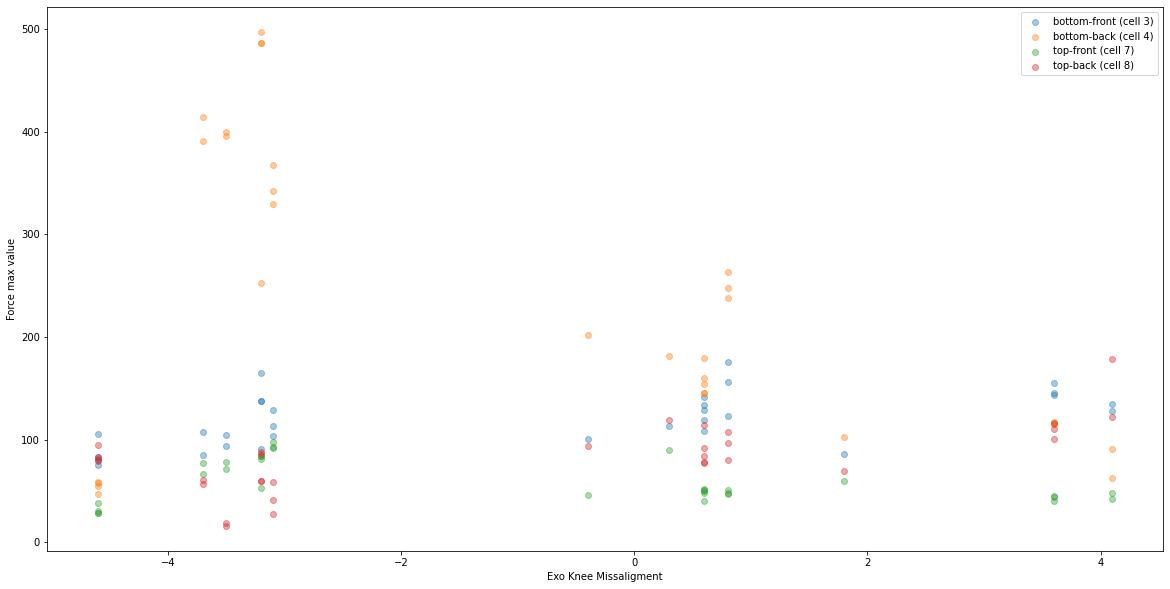

In [20]:
# Plot forces individually
for idx, y, label in zip([3, 4, 7, 8], [y1, y2, y3, y4], ['bottom-front', 'bottom-back', 'top-front', 'top-back']):
    plt.figure(figsize=(20,10))
    plt.title(label + ' (cell {})'.format(idx))
    
    plt.scatter(x, y)
    
    plt.xlabel('Exo Knee Missaligment')
    plt.ylabel('Force {} value'.format(metric))
    plt.show()

# Plot all forces together
plt.figure(figsize=(20,10))

for idx, y, label in zip([3, 4, 7, 8], [y1, y2, y3, y4], ['bottom-front', 'bottom-back', 'top-front', 'top-back']):
    plt.scatter(x, y, label=label + ' (cell {})'.format(idx), alpha=0.4)
    
plt.legend()
plt.xlabel('Exo Knee Missaligment')
plt.ylabel('Force {} value'.format(metric))
plt.show()

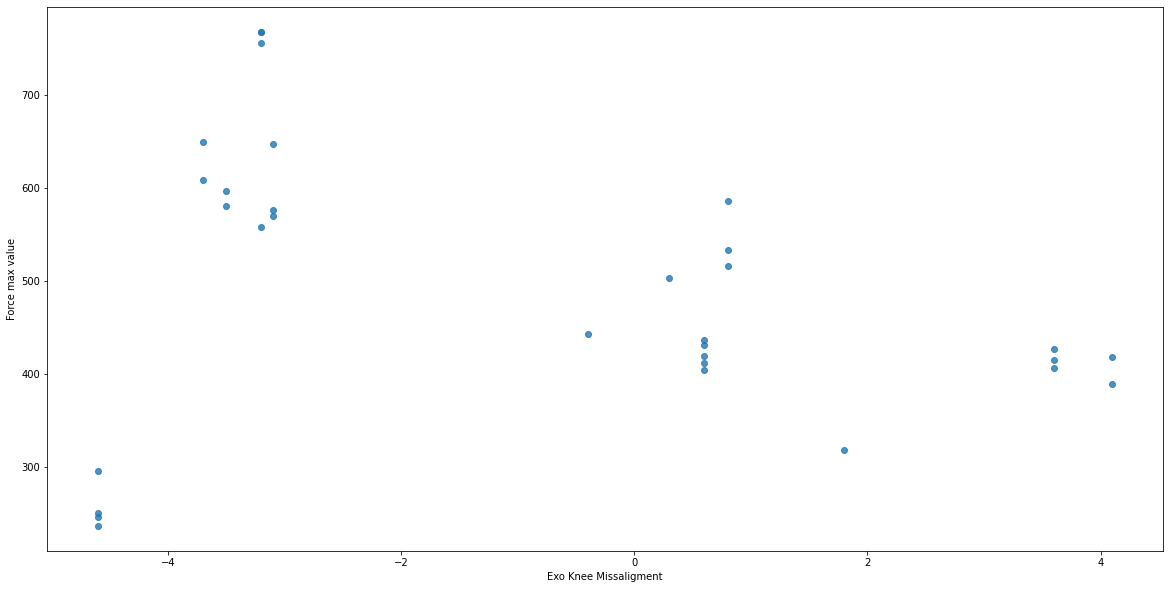

In [22]:
# Plot the sum of all forces
plt.figure(figsize=(20,10))

y = np.array(y1) + np.array(y2) + np.array(y3) + np.array(y4)
plt.scatter(x, y, label=label + ' (cell {})'.format(idx), alpha=0.8)
    
plt.xlabel('Exo Knee Missaligment')
plt.ylabel('Force {} value'.format(metric))
plt.show()